### Load Modules

In [1]:
# path variables
import sys
project_path = '/Users/naresh/Downloads/ds_models/onboarding_fraud_model_v2/'
sys.path.insert(0, project_path+'config')
from config import SQLQuery

# core libraries
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime
import pandas as pd
import numpy as np
import textstat
import nltk
import json
import re
import validators
import requests

from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from model_evaluations import model_metrics, cross_validation
from model_building import tune_hyperparameters
from sklearn.metrics import roc_curve, precision_recall_curve, precision_score, recall_score, roc_auc_score
from matplotlib import pyplot
from collections import Counter
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from fuzzywuzzy import fuzz
from itertools import permutations
from catboost import CatBoostClassifier
from model_building import split_test_train

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


Custom DS Modules

In [2]:
%load_ext autoreload
%autoreload 2
from stability_monitoring import *

### Load the Dataset

In [3]:
# df = pd.read_pickle(project_path+'data/pre_split_engg_data.pkl')
year = '2021_2022'
df_train_raw = pd.read_pickle(project_path+'data/train_engg_data_'+year+'.pkl')
df_test_raw = pd.read_pickle(project_path+'data/test_engg_data_'+year+'.pkl')
df_oot_raw = pd.read_pickle(project_path+'data/oot_engg_data_'+year+'.pkl')

In [4]:
num_features = ['person_fraud_score', 'person_kyc_score', 'sentilink_abuse_score', 'sentilink_first_party_synthetic_score'
            ,'sentilink_third_party_synthetic_score', 'sentilink_id_theft_score', 'socure_sigma', 'socure_emailrisk', 'socure_phonerisk'
            ,'socure_addressrisk','number_of_employees']
num_features2 = ['business_address_zip', 'phone']
bool_features = ['ein_ssn','has_international_business']
cat_features = ['iovation_device_type', 'estimated_monthly_revenue', 'incoming_ach_payments', 'check_deposit_amount'
               , 'incoming_wire_transfer', 'outgoing_ach_and_checks', 'outgoing_wire_transfers', 'line_type', 'industry_category_name']
list_features = ['person_fraud_tags', 'person_kyc_tags', 'socure_reason_code', 'socure_kyc_field_validations'
                ,'socure_kyc_reason_code', 'socure_emailrisk_reason_code', 'socure_phonerisk_reason_code'
                ,'socure_addressrisk_reason_code', 'purpose_of_account', 'touch_point_emails', 'owner_list']
high_cardinality_features = ['iovation_device_timezone', 'iovation_device_ip', 'iovation_device_ip_isp', 'iovation_device_ip_org' 
                            ,'iovation_device_ip_city', 'iovation_device_ip_region', 'carrier', 'email', 'email_domain', 'industry_name'
                            , 'website', 'business_address_city', 'business_address_state', 'industry_category_from_pitch'
                            , 'company_name']
text_features = ['business_pitch']
id_features = ['application_id', 'business_id', 'train_flag', 'test_flag', 'target','expensed_fraud_loss', 'fraud_score', 'deposit_score']
datetime_features = ['application_start_datetime', 'application_complete_datetime', 'application_resubmitted_datetime']



skip_list = num_features2+['line_type','iovation_device_ip','iovation_device_ip_city','iovation_device_ip_region','email',
                           'industry_name','website','business_address_city','business_address_state','industry_category_from_pitch',
                           'company_name','person_fraud_tags','person_kyc_tags','socure_reason_code','socure_kyc_field_validations',
                           'socure_kyc_reason_code','socure_emailrisk_reason_code','socure_phonerisk_reason_code',
                           'socure_addressrisk_reason_code','purpose_of_account','touch_point_emails','owner_list','pos_counts',
                           'owner_name','text_standard','vader_neg','vader_neu','vader_pos','vader_compound','textblob_polarity',
                           'smog_index','coleman_liau_index','gunning_fog','pos_ratios']+id_features+datetime_features+text_features


#### Independent variables

In [5]:
# App features
x_train = df_train_raw.copy(deep=True)
independent_features = set(x_train.columns.to_list()) - set(skip_list)
pd.DataFrame(independent_features, columns=['feature']).to_pickle(project_path+'data/train_independent_features_'+year+'.pkl')

In [6]:
data_type_dict = x_train.dtypes.astype(str).to_dict()
data_type_mapping = {'float64':np.float64,'object':object,'bool':bool,'Int64':np.int64}
data_type_dict = {k: data_type_mapping[v] for k, v in data_type_dict.items() if v in data_type_mapping}

x_train = x_train.astype(data_type_dict)

In [7]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46038 entries, 0 to 46037
Columns: 419 entries, person_fraud_score to owner_name_email_match_flag
dtypes: datetime64[ns](3), float64(102), int64(270), object(44)
memory usage: 147.5+ MB


### Train Data

In [8]:
y_train = x_train['target']

In [9]:
# Removing reason code features as these are already encoded
x_train.drop(columns=skip_list, inplace=True)

# Encoding the categorical features
x_object_cols = x_train.select_dtypes(include=['object']).columns.to_list()
x_object_onehot = pd.get_dummies(x_train[x_object_cols]) # create dummies
x_object_onehot = x_object_onehot.astype('int')
x_train = pd.concat([x_train.drop(columns=x_object_cols), x_object_onehot], axis=1)
x_train.columns = x_train.columns.str.lower() # convert column names to lower case


In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46038 entries, 0 to 46037
Columns: 409 entries, person_fraud_score to text_standard_levels_l3
dtypes: float64(90), int64(319)
memory usage: 144.0 MB


In [11]:
# Save the train data features to use later in the test and oot data preparation
x_train = x_train[x_train.columns]
pd.DataFrame(x_train.columns.to_list(), columns=['feature']).to_pickle(project_path+'models/train_data_columns_'+year+'.pkl')
x_train.shape

(46038, 409)

### Test data

In [12]:
x_test = df_test_raw.copy(deep=True)

y_test = x_test['target']
independent_features = pd.read_pickle(project_path+'data/train_independent_features_'+year+'.pkl')['feature'].to_list()
x_test = x_test[independent_features]

In [13]:
data_type_dict = x_test.dtypes.astype(str).to_dict()
data_type_mapping = {'float64':np.float64,'object':object,'bool':bool,'Int64':np.int64}
data_type_dict = {k: data_type_mapping[v] for k, v in data_type_dict.items() if v in data_type_mapping}

x_test = x_test.astype(data_type_dict)

In [14]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19731 entries, 0 to 19730
Columns: 371 entries, pos_count_NNS to socure_kyc_reason_code_r932
dtypes: float64(90), int64(270), object(11)
memory usage: 55.8+ MB


#### Feature creation

In [15]:
x_test.shape, y_test.shape

((19731, 371), (19731,))

In [16]:
# Removing reason code features as these are already encoded
# x_test.drop(columns=skip_list, inplace=True)

# Encoding the categorical features
x_object_cols = x_test.select_dtypes(include=['object']).columns.to_list()
x_object_onehot = pd.get_dummies(x_test[x_object_cols]) # create dummies
x_object_onehot = x_object_onehot.astype('int')
x_test = pd.concat([x_test.drop(columns=x_object_cols), x_object_onehot], axis=1)
x_test.columns = x_test.columns.str.lower() # convert column names to lower case


In [17]:
# Filter only the final independent features used in the training data
train_cols = pd.read_pickle(project_path+'models/train_data_columns_'+year+'.pkl')['feature'].to_list()
df_tmp = pd.DataFrame(index=range(x_test.shape[0]),columns=train_cols)
df_tmp = df_tmp.fillna(0) # creating a dummy df using the columns from train dataset
df_tmp.update(x_test) # update the dummy df with test df values
x_test = df_tmp.copy()
x_test.shape

(19731, 409)

### OOT Data

In [18]:
x_oot = df_oot_raw.copy(deep=True)
y_oot = x_oot['target']
independent_features = pd.read_pickle(project_path+'data/train_independent_features_'+year+'.pkl')['feature'].to_list()
x_oot = x_oot[independent_features]

In [19]:
data_type_dict = x_oot.dtypes.astype(str).to_dict()
data_type_mapping = {'float64':np.float64,'object':object,'bool':bool,'Int64':np.int64}
data_type_dict = {k: data_type_mapping[v] for k, v in data_type_dict.items() if v in data_type_mapping}

x_oot = x_oot.astype(data_type_dict)

In [20]:
x_oot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4505 entries, 0 to 4504
Columns: 371 entries, pos_count_NNS to socure_kyc_reason_code_r932
dtypes: float64(90), int64(270), object(11)
memory usage: 12.8+ MB


#### Feature creation

In [21]:
x_oot.shape, x_oot.shape

((4505, 371), (4505, 371))

In [22]:
# Removing reason code features as these are already encoded
# x_test.drop(columns=skip_list, inplace=True)

# Encoding the categorical features
x_object_cols = x_oot.select_dtypes(include=['object']).columns.to_list()
x_object_onehot = pd.get_dummies(x_oot[x_object_cols]) # create dummies
x_object_onehot = x_object_onehot.astype('int')
x_oot = pd.concat([x_oot.drop(columns=x_object_cols), x_object_onehot], axis=1)
x_oot.columns = x_oot.columns.str.lower() # convert column names to lower case


In [23]:
# Filter only the final independent features used in the training data
train_cols = pd.read_pickle(project_path+'models/train_data_columns_'+year+'.pkl')['feature'].to_list()
df_tmp = pd.DataFrame(index=range(x_oot.shape[0]),columns=train_cols)
df_tmp = df_tmp.fillna(0) # creating a dummy df using the columns from train dataset
df_tmp.update(x_oot) # update the dummy df with test df values
x_oot = df_tmp.copy()
x_oot.shape

(4505, 409)

### Model Training

In [24]:
# Class imbalance
y_train[y_train==0].shape[0]/y_train.sum(), y_test[y_test==0].shape[0]/y_test.sum()

(29.428288169200265, 29.402157164869028)

#### Initial Model Fit to find the best features: Intuition and reasonable values
First approach is to start with reasonable parameters instead of the default xgboost model

In [25]:
tuned_model = CatBoostClassifier(verbose=100, depth=4, learning_rate=0.05,
                           iterations=2000,
                           loss_function='Logloss',
                           early_stopping_rounds=100,
                           custom_metric=['AUC'], 
                            # auto_class_weights='Balanced', 
                            class_weights=[1,20])
tuned_model.fit(x_train, y_train, eval_set=(x_test, y_test))

0:	learn: 0.6862326	test: 0.6864549	best: 0.6864549 (0)	total: 72.7ms	remaining: 2m 25s
100:	learn: 0.5650527	test: 0.5887781	best: 0.5887781 (100)	total: 994ms	remaining: 18.7s
200:	learn: 0.5397339	test: 0.5821301	best: 0.5821301 (200)	total: 1.89s	remaining: 16.9s
300:	learn: 0.5014791	test: 0.5819512	best: 0.5809578 (229)	total: 2.82s	remaining: 15.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.580957819
bestIteration = 229

Shrink model to first 230 iterations.


TRAIN RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:1  pred:0
true:1     972     541
true:0    8562   35963 

False Positive Rate: 0.19
True Positive Rate: 0.64
AUC: 0.73 

Sensitivity: 0.64
Specificity: 0.81 

F1 Score: 0.18 

KS Score:
KstestResult(statistic=0.17422563968895266, pvalue=0.0, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     44525
         1.0       0.10      0.64      0.18      1513

    accuracy                           0.80     46038
   macro avg       0.54      0.73      0.53     46038
weighted avg       0.96      0.80      0.86     46038

Gain Chart


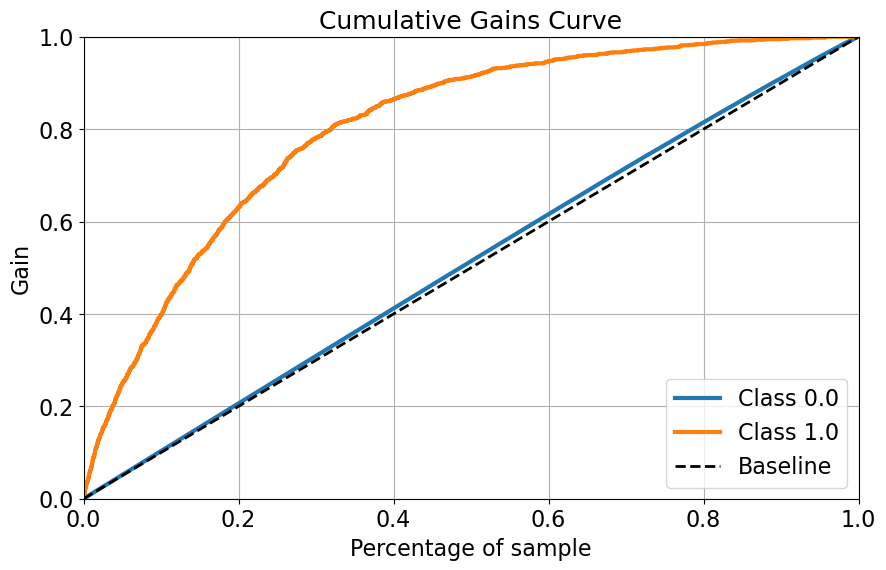

Lift Chart


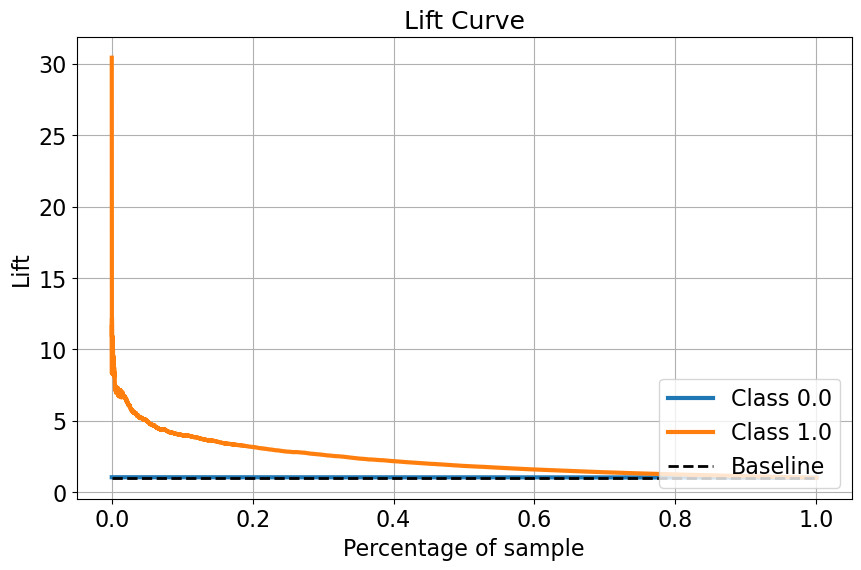



TEST RESULTS:

Accuracy Score: 0.8 

Confusion Matrix:
        pred:1  pred:0
true:1     327     322
true:0    3623   15459 

False Positive Rate: 0.19
True Positive Rate: 0.5
AUC: 0.66 

Sensitivity: 0.5
Specificity: 0.81 

F1 Score: 0.14 

KS Score:
KstestResult(statistic=0.16730018752217324, pvalue=7.733084740533554e-242, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89     19082
         1.0       0.08      0.50      0.14       649

    accuracy                           0.80     19731
   macro avg       0.53      0.66      0.51     19731
weighted avg       0.95      0.80      0.86     19731

Gain Chart


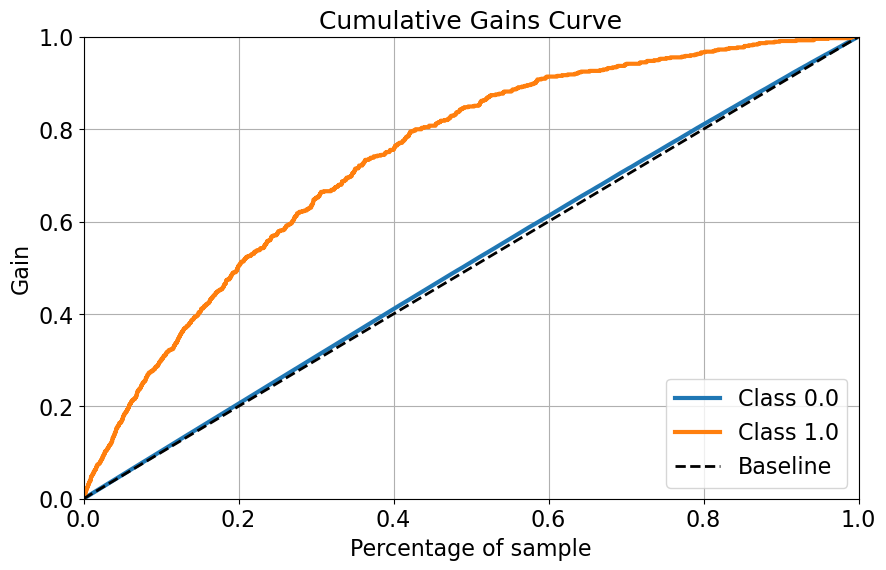

Lift Chart


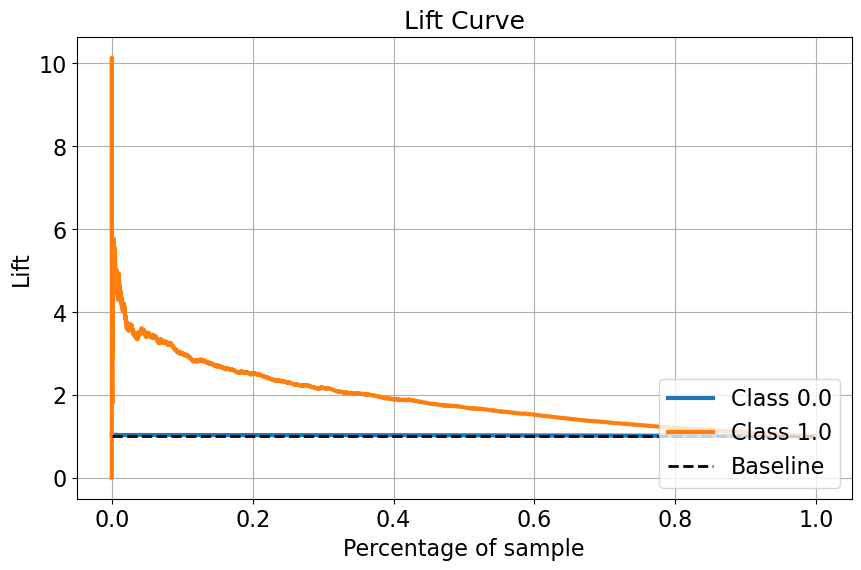



OOT RESULTS:

Accuracy Score: 0.98 

Confusion Matrix:
        pred:1  pred:0
true:1       0      17
true:0      89    4399 

False Positive Rate: 0.02
True Positive Rate: 0.0
AUC: 0.49 

Sensitivity: 0.0
Specificity: 0.98 

F1 Score: 0.0 

KS Score:
KstestResult(statistic=0.01598224195338513, pvalue=0.6128897729927372, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      4488
         1.0       0.00      0.00      0.00        17

    accuracy                           0.98      4505
   macro avg       0.50      0.49      0.49      4505
weighted avg       0.99      0.98      0.98      4505

Gain Chart


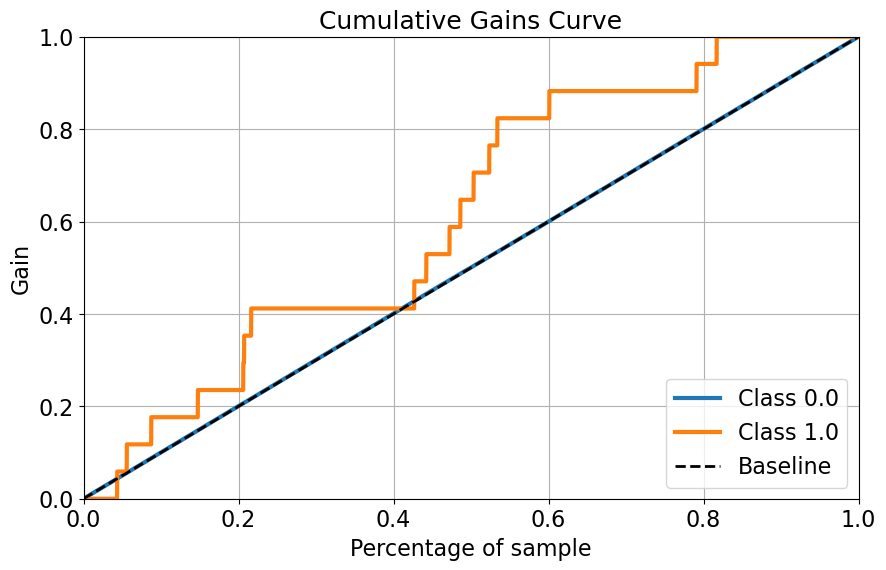

Lift Chart


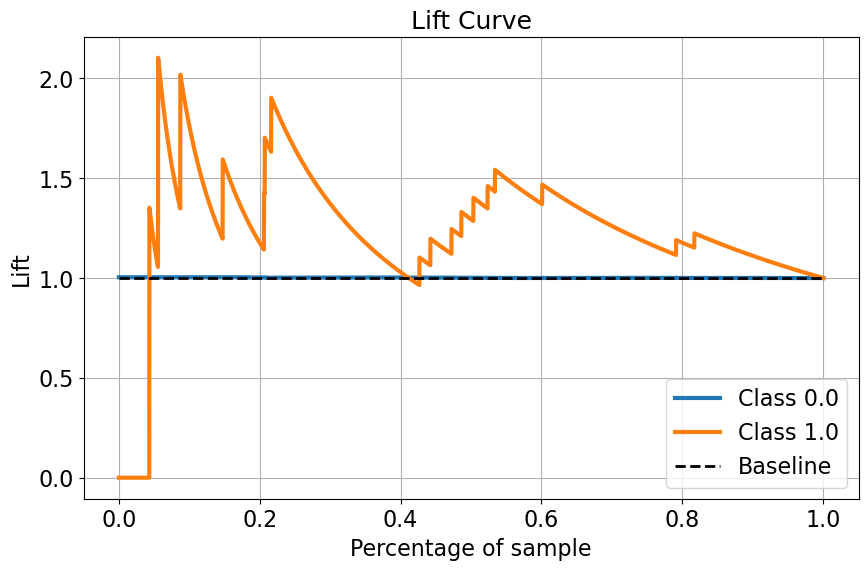

In [26]:
# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model.predict(x_train)
predicted_probas = tuned_model.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model.predict(x_test)
predicted_probas = tuned_model.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model.predict(x_oot)
predicted_probas = tuned_model.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

In [27]:
df_train_raw['proba'] = tuned_model.predict_proba(x_train[train_cols])[:,1:].flatten()
df_test_raw['proba'] = tuned_model.predict_proba(x_test[train_cols])[:,1:].flatten()
df_oot_raw['proba'] = tuned_model.predict_proba(x_oot[train_cols])[:,1:].flatten()

#### Feature Importance

In [28]:
feature_imp_df = pd.DataFrame(zip(x_train.columns.to_list(), tuned_model.feature_importances_), columns=['feature','importance'])
feature_imp_df = feature_imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
feature_imp_df[feature_imp_df.importance>=0.005]

,feature,importance
0,socure_phonerisk,11.630532
1,socure_emailrisk_reason_code_r566,5.841020
2,socure_sigma,3.824462
3,iovation_device_type_android,3.662343
4,total_incoming_vol,3.336541
...,...,...
210,socure_kyc_state_score,0.013586
211,socure_kyc_reason_code_r907,0.011536
212,socure_kyc_reason_code_i909,0.011314
213,pos_count_vbd,0.009374


In [29]:
feature_imp_df[:50]

,feature,importance
0,socure_phonerisk,11.630532
1,socure_emailrisk_reason_code_r566,5.841020
2,socure_sigma,3.824462
3,iovation_device_type_android,3.662343
4,total_incoming_vol,3.336541
5,iovation_device_type_windows,2.650643
6,dale_chall_readability_score,2.466109
7,number_of_employees,2.192526
8,wire_outgoing_vol,1.743360
9,email_domain_other,1.691006


#### Train rank ordering

In [30]:
# train
# custom_bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
custom_bins = [0.0, 0.2, 0.4, 0.6, 1.0]
df_train_raw['proba'] = np.round(df_train_raw['proba'], 3)
df_train_raw['DecileRank']= pd.cut(df_train_raw['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_train_raw.groupby(by='DecileRank')['target'].mean())
df_stats['volume'] = df_train_raw.groupby(by='DecileRank')['target'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats['loss'] = df_train_raw.groupby(by='DecileRank')['expensed_fraud_loss'].sum()
df_stats['loss%'] = np.round((df_stats['loss'] / df_stats['loss'].sum())*100, 2)

df_stats

,target,volume,volume%,loss,loss%
DecileRank,,,,,
"(0.0, 0.2]",0.003526,14464,31.42,18709.27,1.17
"(0.2, 0.4]",0.014019,15479,33.62,162758.84,10.21
"(0.4, 0.6]",0.058685,12286,26.69,832260.61,52.19
"(0.6, 1.0]",0.137569,3809,8.27,580945.10,36.43


#### Test rank ordering

In [31]:
# test
df_test_raw['proba'] = np.round(df_test_raw['proba'], 3)
df_test_raw['DecileRank']= pd.cut(df_test_raw['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_test_raw.groupby(by='DecileRank')['target'].mean())
df_stats['volume'] = df_test_raw.groupby(by='DecileRank')['target'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats['loss'] = df_test_raw.groupby(by='DecileRank')['expensed_fraud_loss'].sum()
df_stats['loss%'] = np.round((df_stats['loss'] / df_stats['loss'].sum())*100, 2)

df_stats

,target,volume,volume%,loss,loss%
DecileRank,,,,,
"(0.0, 0.2]",0.006820,6158,31.21,18472.31,2.41
"(0.2, 0.4]",0.022542,6743,34.17,148381.37,19.37
"(0.4, 0.6]",0.054891,5265,26.68,395448.66,51.62
"(0.6, 1.0]",0.106070,1565,7.93,203762.44,26.60


#### OOT rank ordering

In [32]:
# test
df_oot_raw['proba'] = np.round(df_oot_raw['proba'], 3)
df_oot_raw['DecileRank']= pd.cut(df_oot_raw['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot_raw.groupby(by='DecileRank')['target'].mean())
df_stats['volume'] = df_oot_raw.groupby(by='DecileRank')['target'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum())*100, 2)
df_stats['loss'] = df_oot_raw.groupby(by='DecileRank')['expensed_fraud_loss'].sum()
df_stats['loss%'] = np.round((df_stats['loss'] / df_stats['loss'].sum())*100, 2)

df_stats

,target,volume,volume%,loss,loss%
DecileRank,,,,,
"(0.0, 0.2]",0.003610,2770,61.49,962.64,20.57
"(0.2, 0.4]",0.003509,1425,31.63,3102.39,66.30
"(0.4, 0.6]",0.006667,300,6.66,613.94,13.12
"(0.6, 1.0]",0.000000,10,0.22,0.00,0.00


In [33]:
file_name = 'catboost_model_'+year+'.pkl'
path = project_path + 'models/'
pickle.dump(tuned_model, open(path + file_name, "wb"))

In [34]:
datetime.datetime.now()

datetime.datetime(2024, 6, 18, 9, 20, 27, 352483)

In [ ]:
CatBoostClassifier(verbose=100, depth=4, learning_rate=0.05,
                           iterations=2000,
                           loss_function='Logloss',
                           early_stopping_rounds=100,
                           custom_metric=['AUC'], 
                            # auto_class_weights='Balanced', 
                            class_weights=[1,20])

#### Hyperparameter tuning

In [171]:
estimator = CatBoostClassifier(verbose=100, iterations=2000, loss_function='Logloss', early_stopping_rounds=100)

parameters = {
    'depth': range (2, 6, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    # 'auto_class_weights' : 'Balanced',
    'scale_pos_weight': range(10,25,5)
}

x_train_test = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
y_train_test = np.concatenate([y_train, y_test], axis=0)

best_model = tune_hyperparameters(x_train_test, y_train_test, estimator, parameters, metric='roc_auc', cv_folds=3)


0:	learn: 0.6901963	total: 6.66ms	remaining: 13.3s
100:	learn: 0.5653982	total: 812ms	remaining: 15.3s
200:	learn: 0.5369679	total: 1.79s	remaining: 16s
300:	learn: 0.5237925	total: 2.48s	remaining: 14s
400:	learn: 0.5152242	total: 2.99s	remaining: 11.9s
500:	learn: 0.5088945	total: 3.49s	remaining: 10.4s
600:	learn: 0.5039700	total: 3.99s	remaining: 9.3s
700:	learn: 0.4996276	total: 4.69s	remaining: 8.7s
800:	learn: 0.4960873	total: 5.3s	remaining: 7.94s
900:	learn: 0.4928429	total: 5.94s	remaining: 7.24s
1000:	learn: 0.4895999	total: 6.5s	remaining: 6.48s
1100:	learn: 0.4862207	total: 6.99s	remaining: 5.71s
1200:	learn: 0.4825756	total: 7.46s	remaining: 4.96s
1300:	learn: 0.4791291	total: 7.94s	remaining: 4.26s
1400:	learn: 0.4757627	total: 8.4s	remaining: 3.59s
1500:	learn: 0.4728235	total: 8.86s	remaining: 2.95s
1600:	learn: 0.4699341	total: 9.33s	remaining: 2.33s
1700:	learn: 0.4671956	total: 9.79s	remaining: 1.72s
1800:	learn: 0.4645392	total: 10.3s	remaining: 1.13s
1900:	learn: 

In [174]:
best_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 2000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'od_wait': 100,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 2,
 'posterior_sampling': False,
 'border_count': 254,
 'class_weights': [1, 10],
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 '

TRAIN RESULTS:

Accuracy Score: 0.92 

Confusion Matrix:
        pred:1  pred:0
true:1     242     520
true:0    1098   18405 

False Positive Rate: 0.06
True Positive Rate: 0.32
AUC: 0.63 

Sensitivity: 0.32
Specificity: 0.94 

F1 Score: 0.23 

KS Score:
KstestResult(statistic=0.02852208240809273, pvalue=1.356155034235794e-07, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96     19503
         1.0       0.18      0.32      0.23       762

    accuracy                           0.92     20265
   macro avg       0.58      0.63      0.59     20265
weighted avg       0.94      0.92      0.93     20265

Gain Chart


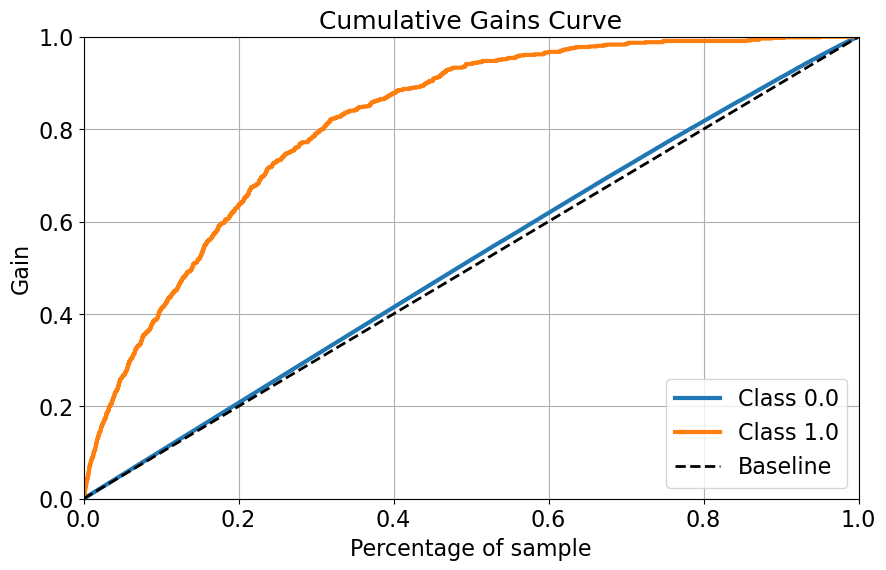

Lift Chart


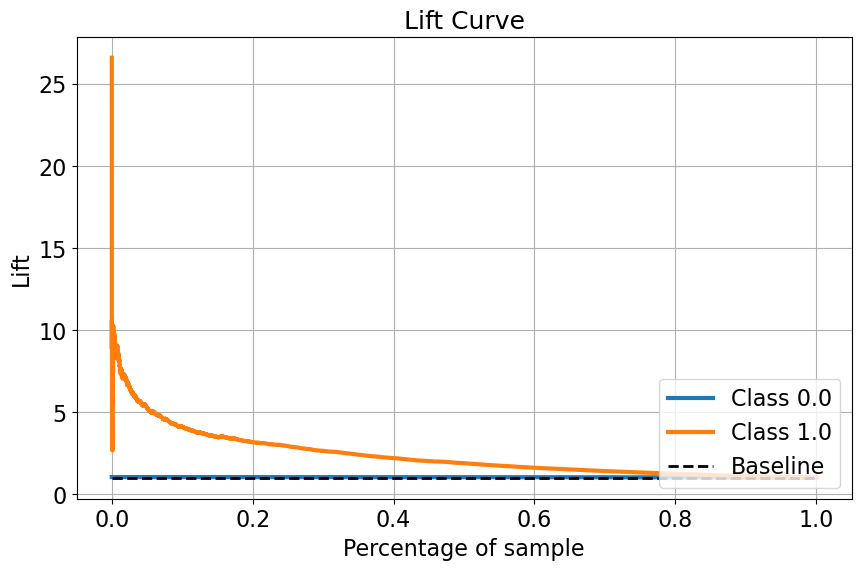



TEST RESULTS:

Accuracy Score: 0.92 

Confusion Matrix:
        pred:1  pred:0
true:1     107     220
true:0     464    7895 

False Positive Rate: 0.06
True Positive Rate: 0.33
AUC: 0.64 

Sensitivity: 0.33
Specificity: 0.94 

F1 Score: 0.24 

KS Score:
KstestResult(statistic=0.02809118121114437, pvalue=0.0021088593135955625, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      8359
         1.0       0.19      0.33      0.24       327

    accuracy                           0.92      8686
   macro avg       0.58      0.64      0.60      8686
weighted avg       0.94      0.92      0.93      8686

Gain Chart


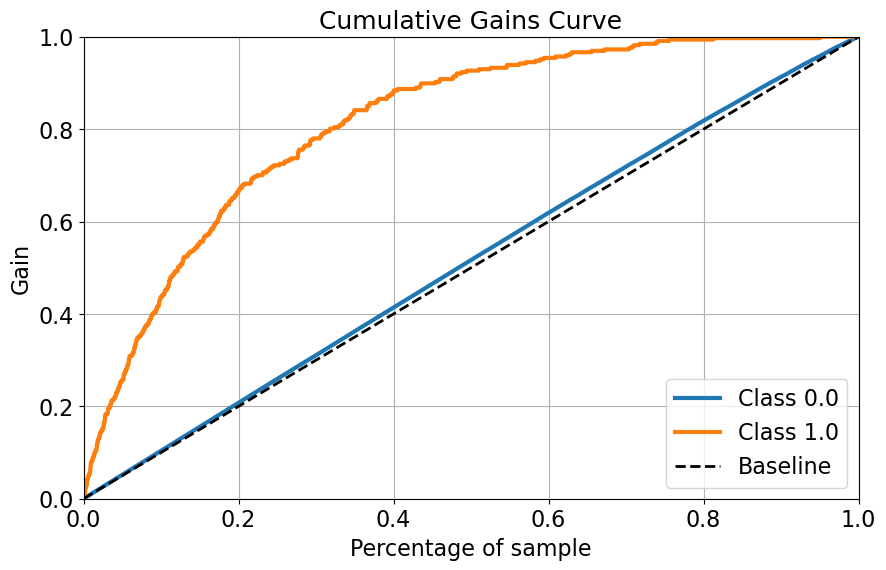

Lift Chart


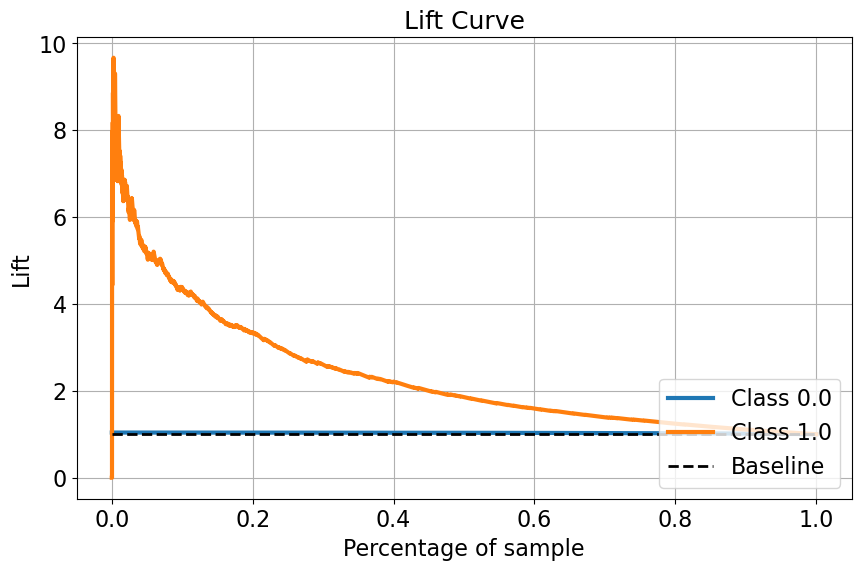



OOT RESULTS:

Accuracy Score: 1.0 

Confusion Matrix:
        pred:1  pred:0
true:1       0      17
true:0       4    4484 

False Positive Rate: 0.0
True Positive Rate: 0.0
AUC: 0.5 

Sensitivity: 0.0
Specificity: 1.0 

F1 Score: 0.0 

KS Score:
KstestResult(statistic=0.0028856825749167593, pvalue=0.9999999999999992, statistic_location=0.0, statistic_sign=1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4488
         1.0       0.00      0.00      0.00        17

    accuracy                           1.00      4505
   macro avg       0.50      0.50      0.50      4505
weighted avg       0.99      1.00      0.99      4505

Gain Chart


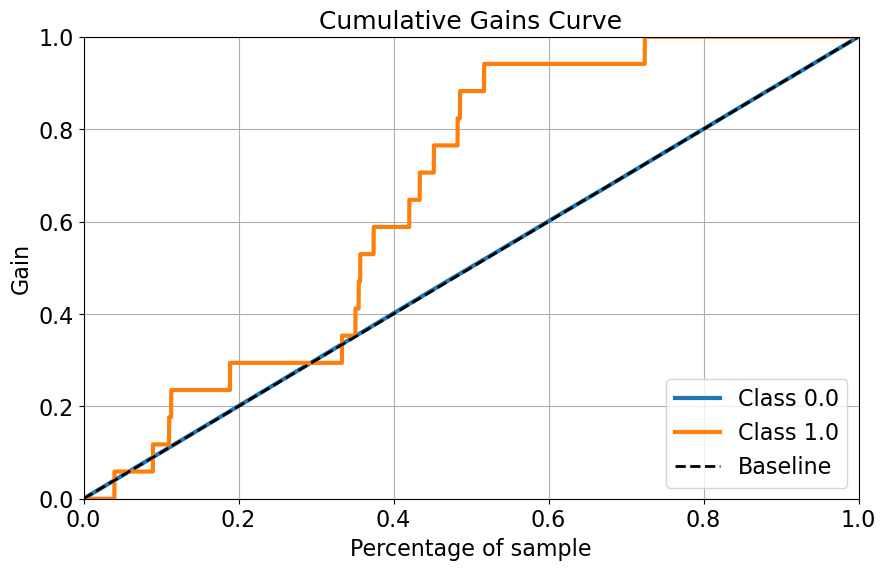

Lift Chart


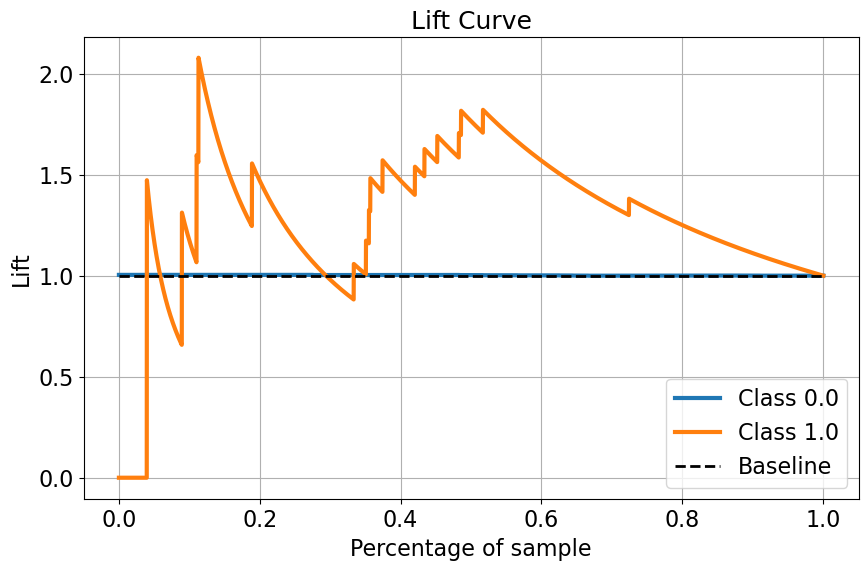

In [175]:
# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = best_model.predict(x_train)
predicted_probas = best_model.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model.predict(x_test)
predicted_probas = best_model.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model.predict(x_oot)
predicted_probas = best_model.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

0:	learn: 0.6893046	total: 5.17ms	remaining: 10.3s
100:	learn: 0.5715560	total: 474ms	remaining: 8.91s
200:	learn: 0.5435047	total: 924ms	remaining: 8.27s
300:	learn: 0.5244767	total: 1.38s	remaining: 7.79s
400:	learn: 0.5001098	total: 1.87s	remaining: 7.47s
500:	learn: 0.4742316	total: 2.33s	remaining: 6.96s
600:	learn: 0.4520280	total: 2.78s	remaining: 6.48s
700:	learn: 0.4328667	total: 3.23s	remaining: 5.99s
800:	learn: 0.4150542	total: 3.67s	remaining: 5.5s
900:	learn: 0.3981722	total: 4.12s	remaining: 5.02s
1000:	learn: 0.3830599	total: 4.57s	remaining: 4.56s
1100:	learn: 0.3684155	total: 5.01s	remaining: 4.09s
1200:	learn: 0.3548315	total: 5.45s	remaining: 3.63s
1300:	learn: 0.3421128	total: 5.92s	remaining: 3.18s
1400:	learn: 0.3306214	total: 6.37s	remaining: 2.72s
1500:	learn: 0.3185156	total: 6.82s	remaining: 2.27s
1600:	learn: 0.3082434	total: 7.27s	remaining: 1.81s
1700:	learn: 0.2981838	total: 7.72s	remaining: 1.36s
1800:	learn: 0.2884583	total: 8.17s	remaining: 902ms
1900:

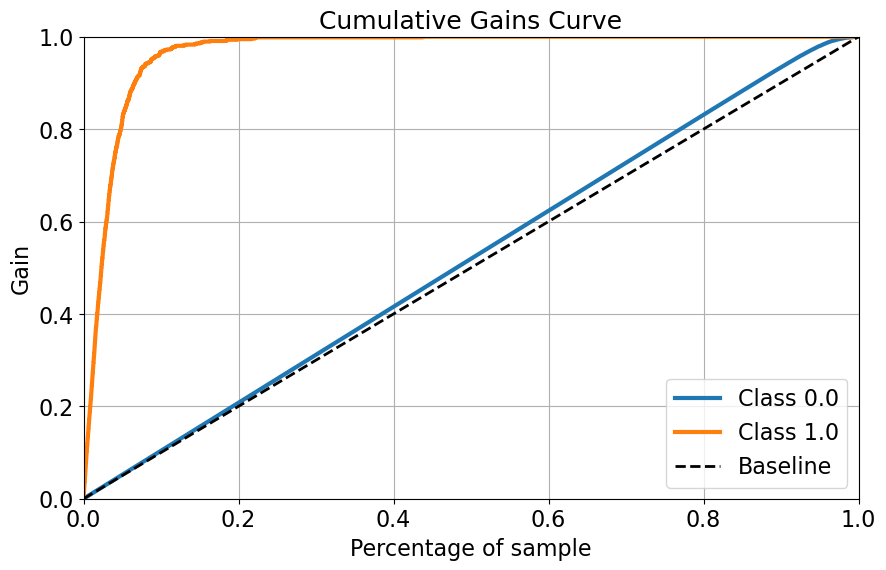

Lift Chart


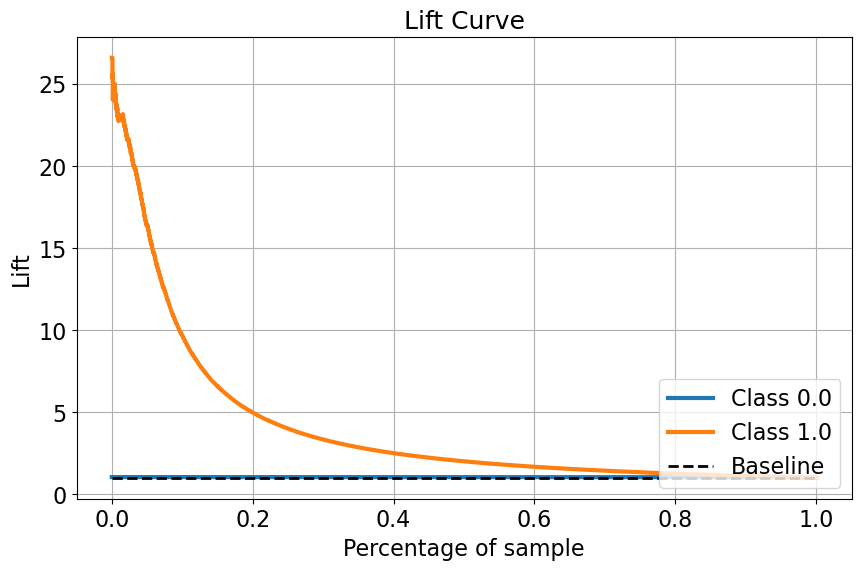



TEST RESULTS:

Accuracy Score: 0.89 

Confusion Matrix:
        pred:1  pred:0
true:1      94     233
true:0     743    7616 

False Positive Rate: 0.09
True Positive Rate: 0.29
AUC: 0.6 

Sensitivity: 0.29
Specificity: 0.91 

F1 Score: 0.16 

KS Score:
KstestResult(statistic=0.05871517384296569, pvalue=1.947432816104191e-13, statistic_location=0.0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      8359
         1.0       0.11      0.29      0.16       327

    accuracy                           0.89      8686
   macro avg       0.54      0.60      0.55      8686
weighted avg       0.94      0.89      0.91      8686

Gain Chart


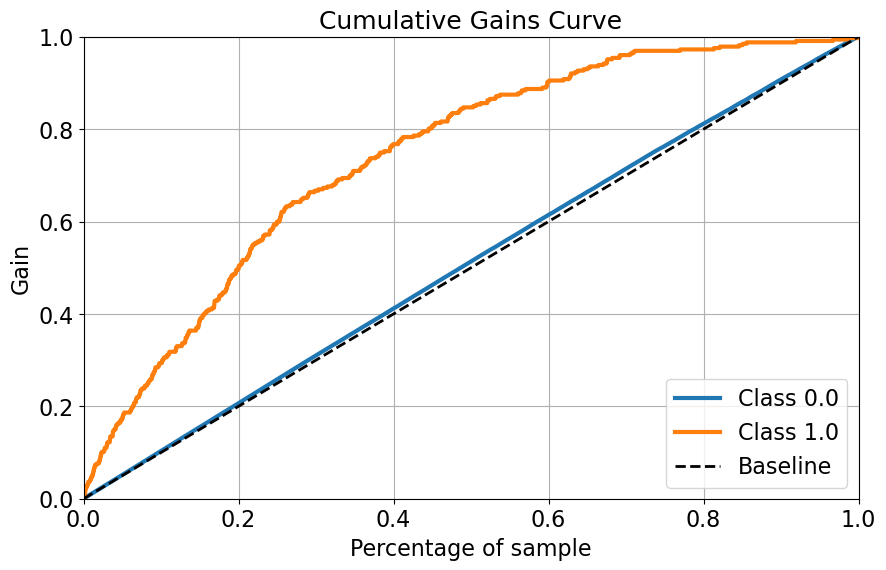

Lift Chart


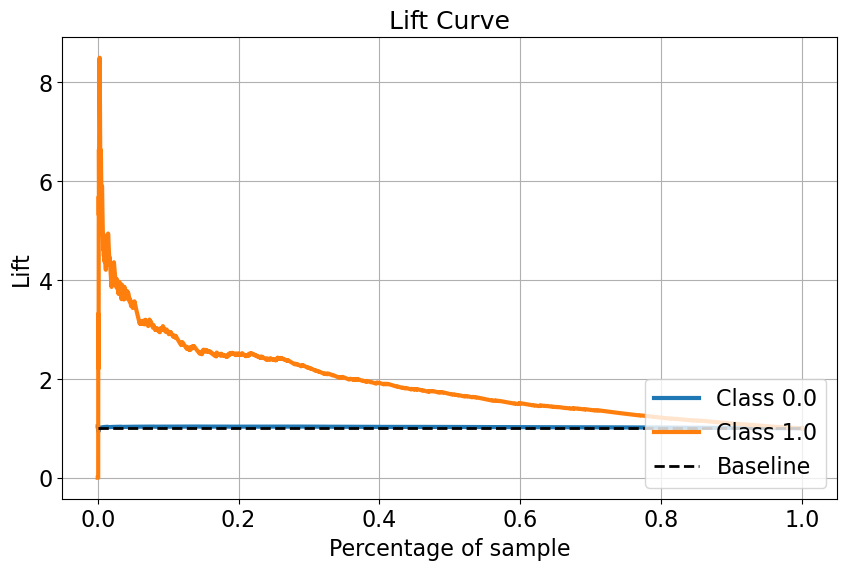



OOT RESULTS:

Accuracy Score: 0.99 

Confusion Matrix:
        pred:1  pred:0
true:1       0      17
true:0       7    4481 

False Positive Rate: 0.0
True Positive Rate: 0.0
AUC: 0.5 

Sensitivity: 0.0
Specificity: 1.0 

F1 Score: 0.0 

KS Score:
KstestResult(statistic=0.0022197558268590455, pvalue=0.9999999999999997, statistic_location=0.0, statistic_sign=1) 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4488
         1.0       0.00      0.00      0.00        17

    accuracy                           0.99      4505
   macro avg       0.50      0.50      0.50      4505
weighted avg       0.99      0.99      0.99      4505

Gain Chart


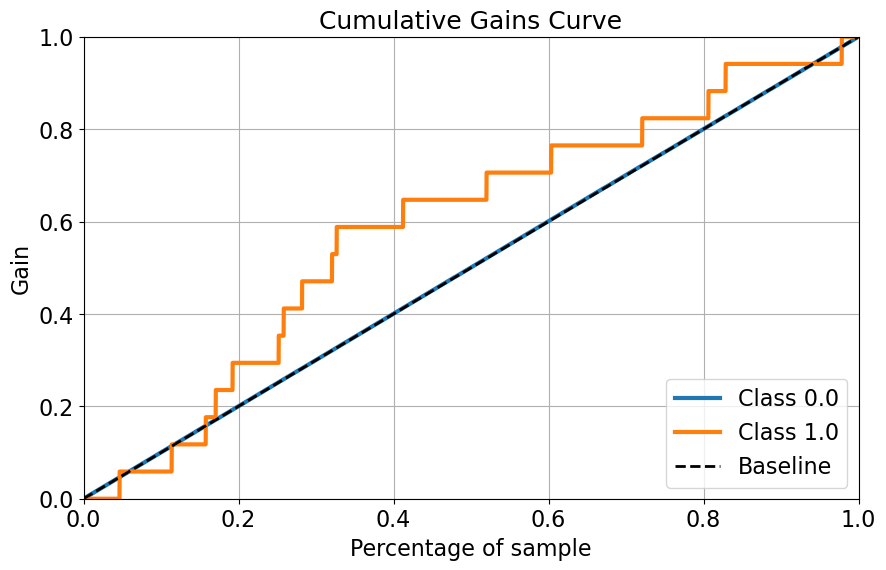

Lift Chart


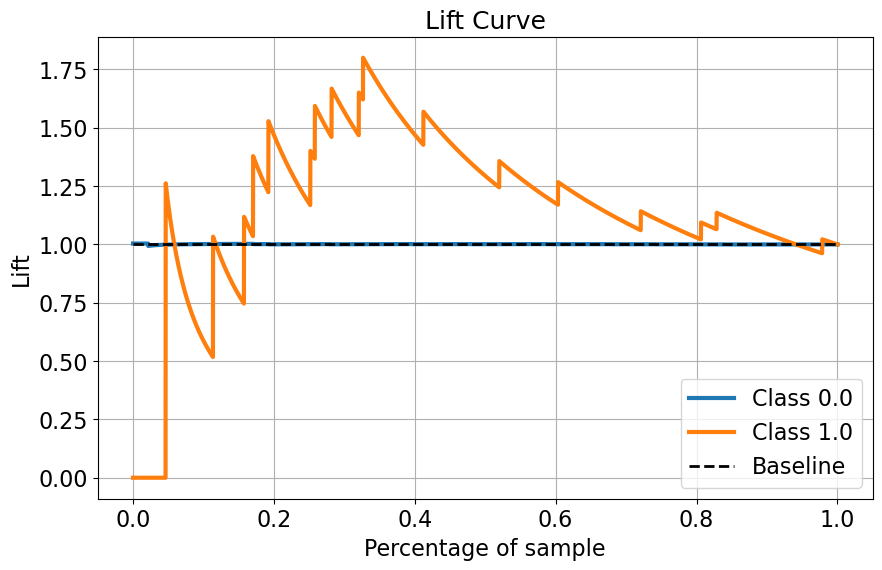

In [183]:
# Prediction on the train, test & oot datasets
best_model2 = CatBoostClassifier(verbose=100, depth=3, iterations=2000, loss_function='Logloss', early_stopping_rounds=100, 
                                 class_weights=[1,18], learning_rate=0.03)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

In [177]:
best_model2.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 2000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'od_wait': 100,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'class_weights': [1, 20],
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 '

In [ ]:
# Prediction on the train, test & oot datasets
best_model2 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=7, learning_rate=0.1)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Prediction on the train, test & oot datasets
best_model2 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=7, learning_rate=0.1)
best_model2.fit(x_train, y_train)

print("TRAIN RESULTS:\n")
y_pred = best_model2.predict(x_train)
predicted_probas = best_model2.predict_proba(x_train)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = best_model2.predict(x_test)
predicted_probas = best_model2.predict_proba(x_test)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = best_model2.predict(x_oot)
predicted_probas = best_model2.predict_proba(x_oot)
model_metrics(y_pred, y_oot, predicted_probas)

#### Selecting the top features basis the model with depth:3 and weight:7, which is producing the better metrics: Precision, Recall & AUC.


In [ ]:
feature_imp_df = pd.DataFrame(zip(x_train.columns.to_list(), best_model2.feature_importances_), columns=['feature','importance'])
feature_imp_df = feature_imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
feature_imp_df[feature_imp_df.importance>=0.005]


In [ ]:
top_features_41 = feature_imp_df[:41]['feature'].to_list()

In [ ]:
# Using the top 41 features, training the model
top_features_41 = feature_imp_df[:41]['feature'].to_list()
x_tr = x_train[top_features_41]
x_te = x_test[top_features_41]
x_oo = x_oot[top_features_41]


tuned_model7 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=7, learning_rate=0.1)
tuned_model7.fit(x_tr, y_train)

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model7.predict(x_tr)
predicted_probas = tuned_model7.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model7.predict(x_te)
predicted_probas = tuned_model7.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model7.predict(x_oo)
predicted_probas = tuned_model7.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

### Selecting the optimal number of features

In [ ]:
# Feature Importance Custom Function
def feature_importance(model, X, imp_type='gain'):
    '''
    Returns the best binary classifier with tuned hyperparameter set

        Parameters:
                model (object): model object of the binary classifier
                X (dataframe(pandas)): pandas dataframe of predictor variables in train dataset
                imp_type (str): importance type to be plotted from the model, choose from ['gain', 'cover', 'weight', 'total_gain', 'total_cover']
        
        Prints:
                feat_importances (plot): plots the feature importance

        Returns:
                feat_importance (dataframe(pandas)): pandas dataframe of feature importances

        Raises:
                ValueError: If X is not pandas dataframe
    '''
    # Check if train dataset is passed as dataframe
    if type(X) != pd.core.frame.DataFrame:
        raise ValueError('Train dataset not passed as pandas dataframe')
    
    # Check if the classifier is tree based
    if type(model).__name__ in (['DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier']):
        importance_array = model.feature_importances_
    else:
        importance_array = model.coef_[0]
    
    # Extract the feature importance
    feat_importances = pd.DataFrame(importance_array, index=X.columns, columns=['importance'])

    # Plot the feature importance
    # fig = px.bar(feat_importances, orientation='h')
    # fig.update_layout(yaxis={'categoryorder':'total ascending'})
    # fig.show()

    # Return the feature importance dataframe
    return feat_importances
imp = feature_importance(tuned_model7, x_train[top_features_41], imp_type='total_gain')


In [ ]:
imp_idx = imp.sort_values(by='importance', ascending=False).index[:41]
imp = imp.loc[imp_idx]

In [ ]:
imp.reset_index()

In [ ]:
imp.shape

Find the optimal number of features

In [ ]:
# functions to build models with different feature counts by iteratively removing least important features
def get_feature_importance(X_train, X_test):
    xgb_model = XGBClassifier(max_depth=3, scale_pos_weight=7 ,learning_rate=0.1 ,random_state=3
                              ,eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    imp = feature_importance(xgb_model, X_train, imp_type='total_gain')
    return imp,xgb_model

def imp_iter(X_train,X_test,imp_data,threshold):
    X_train_temp = X_train.copy()
    X_test_temp = X_test.copy()
    while X_train_temp.shape[1] > threshold:
        features = list(X_train_temp.columns)
        feature_exc = imp_data.sort_values(by='importance', ascending=True).index[0]
        features.remove(feature_exc)
        X_train_temp = X_train_temp[features]
        X_test_temp = X_test_temp[features]
        imp_data, xgb_model2 = get_feature_importance(X_train_temp, X_test_temp)
    print(imp_data.shape[0])
    pd.DataFrame(imp_data.index.to_list(), columns=['column']).to_pickle(project_path+'models_tmp2/top_features_'+str(threshold)+'.pkl')
    pickle.dump(xgb_model2, open(f'{project_path}models_tmp2/xgb_{threshold}.pkl', 'wb'))
    return

def var_imp_iter(X_train,X_test,imp_data,var_arr):
    for threshold in var_arr:
        imp_iter(X_train, X_test, imp_data, threshold)
    return

In [ ]:
x_train2 = x_train[top_features_41]
x_test2 = x_test[top_features_41]

In [ ]:
# iteratively removing features one by one and saving models with the provided feature counts list.
arr = [10,15,20,25,30,35,40]
var_imp_iter(x_train2,x_test2,imp,arr)

In [ ]:
# Loading models and comparing their AUC performance
features_count_arr = [40,35,30,25,20,15,10]
model_arr = []
for threshold in features_count_arr:
    model_arr.append(pickle.load(open(f'{project_path}models_tmp2/xgb_{threshold}.pkl', "rb")))
model_arr

Running each model with iterations over 50 seeds, to check the performance metrics and finalise the number of features for the model.

In [ ]:
%load_ext autoreload
%autoreload 2

from modules.validation import validator
val = validator()

In [ ]:
def run_pipe_test(df,  dependent_variable, model, threshold):
    
    print('\n\nNumber of features: ',threshold)
    # Set seed for train test split 
#     selected_features = model.feature_names_in_
    selected_features = pd.read_pickle(project_path+'models_tmp2/top_features_'+str(threshold)+'.pkl')['column'].to_list()
    traindict0, testdict0   = val.rank_order_test(df, selected_features, dependent_variable, model, 0)
    
    results_df = pd.DataFrame(columns=['seed', 
                               'accuracy_train','accuracy_test',
                               'auc_train','auc_test', 
                               'precision_train','precision_test', 
                               'recall_train','recall_test',
                              'fpr_train','fpr_test',
                              'tpr_train','tpr_test',
                              'sensitivity_train','sensitivity_test',
                              'specificity_train','specificity_test'])
    dict0 = {'seed':0, 
             'accuracy_train': traindict0['accuracy_score'], 'accuracy_test':testdict0['accuracy_score'],
             'auc_train' : traindict0['AUC'], 'auc_test' : testdict0['AUC'],
             'precision_train':traindict0['precision'],'precision_test':testdict0['precision'],
             'recall_train':traindict0['recall'], 'recall_test':testdict0['recall'],
             'fpr_train':traindict0['FPR'], 'fpr_test':testdict0['FPR'],
             'tpr_train':traindict0['TPR'], 'tpr_test':testdict0['TPR'],
             'sensitivity_train':traindict0['Sensitivity'], 'sensitivity_test':testdict0['Sensitivity'],
             'specificity_train':traindict0['Specificity'], 'specificity_test':testdict0['Specificity']
            }
    results_df = results_df.append(dict0,ignore_index=True)
    
    for seed in range(1,50):
        print('Seed number: ',seed)
        traindict1, testdict1  = val.rank_order_test(df, selected_features, dependent_variable, model, seed)
        
        dict1 = {'seed':0, 
                 'accuracy_train': traindict1['accuracy_score'], 'accuracy_test':testdict1['accuracy_score'],
                 'auc_train' : traindict1['AUC'], 'auc_test' : testdict1['AUC'],
                 'precision_train':traindict1['precision'],'precision_test':testdict1['precision'],
                 'recall_train':traindict1['recall'], 'recall_test':testdict1['recall'],
                 'fpr_train':traindict1['FPR'], 'fpr_test':testdict1['FPR'],
                 'tpr_train':traindict1['TPR'], 'tpr_test':testdict1['TPR'],
                 'sensitivity_train':traindict1['Sensitivity'], 'sensitivity_test':testdict1['Sensitivity'],
                 'specificity_train':traindict1['Specificity'], 'specificity_test':testdict1['Specificity']
                }
        results_df = results_df.append(dict1,ignore_index=True)
    
    return results_df


In [ ]:
x_train_test2 = pd.concat([x_train2, x_test2], axis=0).reset_index(drop=True)
y_train_test2 = pd.DataFrame(np.concatenate([y_train, y_test], axis=0), columns=['ns_flag'])

In [ ]:
aucdf = run_pipe_test(x_train_test2.join(y_train_test2),'ns_flag',model_arr[0],max(features_count_arr))
aucdf['tag'] = 'base'

aucdf_main = aucdf.copy()

# for tag,modelx in zip(features_count_arr,model_arr):
for tag,modelx in zip(features_count_arr,model_arr):
    aucdftmp = run_pipe_test(x_train_test2.join(y_train_test2),'ns_flag',modelx, tag)
    aucdftmp['tag'] = tag
    aucdf_main = aucdf_main.append(aucdftmp)

In [ ]:
aucdf_main

In [ ]:
aucdf_main_2 = aucdf_main[~(aucdf_main['tag']=='base')]

#### AUC

In [ ]:
# Plotting the train and test AUC scores of each model averaged over 50 iterations
df_plot = aucdf_main_2.copy()
col_train = 'auc_train'
col_test = 'auc_test'

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y=col_train, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y=col_test, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))

plt.show()

Train:
- AUC is best at 30 & 40 features, because the variation in the values is less. It explains the model is stable with varying data splits

Test:
- AUC is flat at 30, 35 & 40 features

Basis the above observations the optimal features selected are 30.

#### Recall

In [ ]:
# Plotting the train and test recall scores of each model averaged over 50 iterations
df_plot = aucdf_main_2.copy()
col_train = 'recall_train'
col_test = 'recall_test'

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y=col_train, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y=col_test, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))

plt.show()

Train:
- Recall is best at 30 & 40 features, because the variation in the values is less. It explains the model is stable with varying data splits

Test:
- Recall is best and flat at 30, 35 & 40 features

Basis the above observations the optimal features selected are 30.

#### Precision

In [ ]:
# Plotting the train and test precision scores of each model averaged over 50 iterations
df_plot = aucdf_main_2.copy()
col_train = 'precision_train'
col_test = 'precision_test'

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y=col_train, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y=col_test, data=df_plot)  # RUN PLOT   
ax.set_ylim(min([min(df_plot[col_train]), min(df_plot[col_test])]), max([max(df_plot[col_train]), max(df_plot[col_test])]))

plt.show()

The number of optimal features selected are 30, because the precision value should be greather than or equal to NSL V1 model which comes to be 23%

In [ ]:
# Save the top 30 features
top30_features = pd.read_pickle(project_path+'models_tmp2/top_features_30.pkl')['column'].to_list()

In [ ]:
top30_features

Tried running grid search but couldn't get better performance models.
But observed better model metrics by manually varying depth & class weight. So, finlalised the best model basis the model metrics.

In [ ]:
estimator2 = XGBClassifier(random_state=3, eval_metric='logloss')

parameters = {
    'max_depth': range (2, 5, 1),
    'learning_rate': [0.05, 0.1, 0.15],
    'scale_pos_weight' : range(4, 8, 1)
}


x_train_test = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)
y_train_test = np.concatenate([y_train, y_test], axis=0)

best_model_v2 = tune_hyperparameters(x_train_test[top30_features], y_train_test, estimator2, parameters, metric='roc_auc', cv_folds=3)


In [ ]:
# Depth:4 and Weight:5
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=5, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 5
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:4 and Weight:6
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=6, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 6
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:4 and Weight:7
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=7, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 7
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:4 and Weight:8
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=4, scale_pos_weight=8, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 4
weight = 8
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:3 and Weight:5
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=5, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 5
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:3 and Weight:6
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=6, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 6
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:3 and Weight:7
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=7, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 7
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)

In [ ]:
# Depth:3 and Weight:8
x_tr = x_train[top30_features]
x_te = x_test[top30_features]
x_oo = x_oot[top30_features]


tuned_model6 = XGBClassifier(random_state=3, max_depth=3, scale_pos_weight=8, learning_rate=0.1, eval_metric='logloss')
tuned_model6.fit(x_tr, y_train)

###################################
depth = 3
weight = 8
file_name = 'nsql_model_depth_'+str(depth)+'_weight_'+str(weight)+'.pkl'
path = project_path + 'models_tmp2/'
pickle.dump(tuned_model6, open(path + file_name, "wb"))
###################################

# Prediction on the train, test & oot datasets
print("TRAIN RESULTS:\n")
y_pred = tuned_model6.predict(x_tr)
predicted_probas = tuned_model6.predict_proba(x_tr)
model_metrics(y_pred, y_train, predicted_probas)

print("\n\nTEST RESULTS:\n")
y_pred = tuned_model6.predict(x_te)
predicted_probas = tuned_model6.predict_proba(x_te)
model_metrics(y_pred, y_test, predicted_probas)

print("\n\nOOT RESULTS:\n")
y_pred = tuned_model6.predict(x_oo)
predicted_probas = tuned_model6.predict_proba(x_oo)
model_metrics(y_pred, y_oot, predicted_probas)


In [ ]:
top30_features

### Conclusion:
- The model with depth 4 and class weight 6 is selected as the best model based on the Recall, Precision and AUC